# Locus Coeruleus & Peri-LC Neuromodulator Receptor Expression (MERFISH)

This notebook examines neuromodulator receptor expression in the **locus coeruleus (LC)**
and surrounding pontine structures using MERFISH spatial transcriptomics from the Allen
Brain Cell Atlas.

### Regions
- **LC** — locus coeruleus (124 cells; primary noradrenergic nucleus)
- **SLC** — sublocus coeruleus (223 cells)
- **B** — Barrington's nucleus (121 cells; adjacent to LC)
- **PB** — parabrachial nucleus (10,465 cells; pain/temperature/taste relay)
- **LDT** — laterodorsal tegmental nucleus (1,646 cells; cholinergic)
- **DTN** — dorsal tegmental nucleus (1,288 cells)
- **NI** — nucleus incertus (1,084 cells)
- **SLD** — sublaterodorsal nucleus (372 cells; REM sleep)
- **PDTg** — posterodorsal tegmental nucleus (518 cells)

### Key cell type
- **NTS Dbh Glut** — noradrenergic neurons (Dbh+), the core LC cell type

### MERFISH Gene Panel (11 receptors)
- **Serotonin (5)**: Htr1b, Htr1d, Htr2a, Htr3a, Htr7
- **Norepinephrine (2)**: Adra1a, Adra1b
- **Dopamine (4)**: Drd1, Drd2, Drd3, Drd5

In [1]:
import pandas as pd
import numpy as np
import re
import os
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

## 1. Initialize Cache and Load Metadata

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
print(f'Manifest: {abc_cache.current_manifest}')

Manifest: releases/20251031/manifest.json


/home/user/abc_atlas_access/src/abc_atlas_access/abc_atlas_cache/cloud_cache.py:679: OutdatedManifestWarning: You are loading releases/20251031/manifest.json. A more up to date version of the dataset -- releases/20260131/manifest.json -- exists online. To see the changes between the two versions of the dataset, run
type.compare_manifests('releases/20251031/manifest.json', 'releases/20260131/manifest.json')
To load another version of the dataset, run
type.load_manifest('releases/20260131/manifest.json')
  warnings.warn(msg, OutdatedManifestWarning)


In [3]:
ccf_meta = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850-CCF',
    file_name='cell_metadata_with_parcellation_annotation',
    dtype={'cell_label': str}
)
ccf_meta.set_index('cell_label', inplace=True)
print(f'Total MERFISH cells with CCF: {len(ccf_meta):,}')

Total MERFISH cells with CCF: 3,739,961


## 2. Identify LC and Peri-LC Cells

Select cells from the locus coeruleus and surrounding pontine structures.

In [4]:
# Core LC structures
core_lc = ['LC', 'SLC']
# Peri-LC structures (immediate neighbors in dorsal pons)
peri_lc = ['B', 'PB', 'LDT', 'DTN', 'NI', 'SLD', 'PDTg']
all_structures = core_lc + peri_lc

lc_region = ccf_meta[ccf_meta['parcellation_structure'].isin(all_structures)].copy()
print(f'Total cells in LC + peri-LC: {len(lc_region):,}')

print(f'\nCells per structure:')
for s in all_structures:
    cnt = (lc_region['parcellation_structure'] == s).sum()
    tag = '(core)' if s in core_lc else '(peri)'
    print(f'  {s:6s} {tag}: {cnt:>6,} cells')

Total cells in LC + peri-LC: 15,841

Cells per structure:
  LC     (core):    124 cells
  SLC    (core):    223 cells
  B      (peri):    121 cells
  PB     (peri): 10,465 cells
  LDT    (peri):  1,646 cells
  DTN    (peri):  1,288 cells
  NI     (peri):  1,084 cells
  SLD    (peri):    372 cells
  PDTg   (peri):    518 cells


In [5]:
# Neuronal vs non-neuronal breakdown
lc_region['is_neuronal'] = ~lc_region['class'].str.contains('NN', na=False)

print('Cell classes in LC + peri-LC:')
for c, cnt in lc_region.groupby('class', observed=True).size().sort_values(ascending=False).items():
    print(f'  {c}: {cnt:,}')

neurons = lc_region[lc_region['is_neuronal']]
print(f'\nNeurons: {len(neurons):,} / {len(lc_region):,} total')

Cell classes in LC + peri-LC:
  23 P Glut: 4,251
  31 OPC-Oligo: 3,224
  30 Astro-Epen: 2,785
  33 Vascular: 1,831
  26 P GABA: 1,652
  24 MY Glut: 598
  20 MB GABA: 512
  19 MB Glut: 284
  27 MY GABA: 235
  34 Immune: 174
  29 CB Glut: 165
  22 MB-HB Sero: 80
  28 CB GABA: 32
  14 HY Glut: 13
  12 HY GABA: 4
  13 CNU-HYa Glut: 1

Neurons: 15,841 / 15,841 total


In [6]:
# Neuronal subclasses in peri-LC region (>= 10 cells)
neuron_sc = neurons.groupby('subclass', observed=True).size().sort_values(ascending=False)
print(f'Neuronal subclasses (>= 10 cells):')
for sc_name, cnt in neuron_sc.items():
    if cnt >= 10:
        # Show which structures they're in
        structs = neurons[neurons['subclass'] == sc_name].groupby(
            'parcellation_structure', observed=True
        ).size().sort_values(ascending=False)
        struct_str = ', '.join([f'{s}:{c}' for s, c in structs.head(4).items()])
        print(f'  {sc_name}: {cnt:,}  [{struct_str}]')

# Highlight Dbh+ (noradrenergic) neurons
dbh_mask = lc_region['subclass'].str.contains('Dbh', na=False)
dbh_cells = lc_region[dbh_mask]
print(f'\nDbh+ (noradrenergic) neurons: {len(dbh_cells):,}')
for s, cnt in dbh_cells.groupby('parcellation_structure', observed=True).size().sort_values(ascending=False).items():
    print(f'  {s}: {cnt}')

Neuronal subclasses (>= 10 cells):
  327 Oligo NN: 2,864  [PB:2225, LDT:190, NI:143, DTN:109]
  318 Astro-NT NN: 2,746  [PB:1770, LDT:287, DTN:217, NI:206]
  222 PB Evx2 Glut: 1,640  [PB:1585, LC:29, LDT:17, B:7]
  333 Endo NN: 1,341  [PB:841, LDT:143, NI:123, DTN:108]
  217 PB Lmx1a Glut: 1,190  [PB:1171, LC:9, LDT:8, SLC:2]
  277 DTN-LDT-IPN Otp Pax3 Gaba: 546  [DTN:400, LDT:90, NI:50, PDTg:5]
  326 OPC NN: 360  [PB:245, LDT:43, NI:21, DTN:17]
  200 PAG-ND-PCG Onecut1 Gaba: 315  [DTN:228, NI:47, LDT:26, SLD:12]
  229 PB-NTS Phox2b Ebf3 Lmx1b Glut: 296  [PB:292, SLC:2, LC:1, B:1]
  221 LDT-PCG Vsx2 Lhx4 Glut: 284  [LDT:173, NI:40, PDTg:26, PB:21]
  220 PB Pax5 Glut: 260  [PB:217, LDT:42, B:1]
  331 Peri NN: 235  [PB:147, LDT:28, NI:22, DTN:16]
  243 PGRN-PARN-MDRN Hoxb5 Glut: 232  [PB:199, LDT:10, NI:9, SLC:6]
  251 NTS Dbh Glut: 215  [PB:123, SLC:31, LC:24, LDT:24]
  182 CUN-PPN Evx2 Meis2 Glut: 213  [PB:128, LDT:78, SLC:2, LC:2]
  273 PDTg-PCG Pax6 Gaba: 205  [PDTg:163, LDT:18, NI:1

## 3. Load Receptor Gene Metadata

In [7]:
gene = abc_cache.get_metadata_dataframe(directory='MERFISH-C57BL6J-638850', file_name='gene')
gene.set_index('gene_identifier', inplace=True)

serotonin_receptors = ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7']
norepinephrine_receptors = ['Adra1a', 'Adra1b']
dopamine_receptors = ['Drd1', 'Drd2', 'Drd3', 'Drd5']
all_receptors = serotonin_receptors + norepinephrine_receptors + dopamine_receptors

available_genes = gene[gene['gene_symbol'].isin(all_receptors)]
receptor_genes = [g for g in all_receptors if g in set(available_genes['gene_symbol'])]
gene_ensembl_ids = available_genes.index.tolist()
print(f'Receptor genes in MERFISH: {len(receptor_genes)} — {receptor_genes}')

Receptor genes in MERFISH: 11 — ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7', 'Adra1a', 'Adra1b', 'Drd1', 'Drd2', 'Drd3', 'Drd5']


## 4. Extract Expression Data

In [8]:
csv_expr = 'lc_merfish_expression.csv'
csv_meta = 'lc_merfish_metadata.csv'

if os.path.exists(csv_expr):
    expression_data = pd.read_csv(csv_expr, index_col=0)
    print(f'Loaded from {csv_expr}: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes')
else:
    file_path = abc_cache.get_file_path(
        directory='MERFISH-C57BL6J-638850',
        file_name='C57BL6J-638850/log2'
    )
    print(f'Loading MERFISH expression: {os.path.getsize(file_path) / 1e9:.1f} GB')
    
    adata = anndata.read_h5ad(file_path, backed='r')
    print(f'Matrix: {adata.shape[0]:,} cells x {adata.shape[1]} genes')
    
    gene_mask = adata.var.index.isin(gene_ensembl_ids)
    cell_mask = adata.obs.index.isin(lc_region.index)
    cell_idx = np.where(cell_mask)[0]
    gene_idx = np.where(gene_mask)[0]
    
    print(f'LC+peri-LC cells found: {len(cell_idx):,}')
    print(f'Receptor genes found: {len(gene_idx)}')
    
    subset = adata[cell_idx, gene_idx].to_memory()
    gene_filtered = adata.var[gene_mask]
    expression_data = subset.to_df()
    expression_data.columns = gene_filtered['gene_symbol'].values
    expression_data = expression_data[receptor_genes]
    
    adata.file.close()
    del adata
    
    expression_data.to_csv(csv_expr)
    print(f'Saved to {csv_expr}')

# Save metadata
meta_cols = ['subclass', 'supertype', 'class', 'neurotransmitter',
             'parcellation_structure', 'parcellation_substructure',
             'parcellation_division']
lc_region.loc[expression_data.index, meta_cols].to_csv(csv_meta)
print(f'\nExtracted: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes')

Loaded from lc_merfish_expression.csv: 15,841 cells x 11 genes

Extracted: 15,841 cells x 11 genes


## 5. Dot Plot: All Cell Types in LC + SLC (Core)

Focus on the core locus coeruleus and subcoeruleus, showing all cell types
including the noradrenergic Dbh+ neurons.

In [9]:
meta = lc_region.loc[expression_data.index].copy()
meta['supertype_short'] = meta['supertype'].apply(
    lambda x: re.sub(r'^\d+\s+', '', str(x))
)
meta['subclass_short'] = meta['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', str(x))
)
meta['structure'] = meta['parcellation_structure']

# Core LC+SLC cells
core_mask = meta['structure'].isin(core_lc)
core_meta = meta[core_mask].copy()
core_expr = expression_data.loc[core_mask]

# Show subclass distribution in core LC+SLC
print(f'Core LC+SLC cells: {len(core_meta):,}')
print(f'\nSubclasses (core LC+SLC):')
for sc_name, cnt in core_meta.groupby('subclass_short', observed=True).size().sort_values(ascending=False).items():
    structs = core_meta[core_meta['subclass_short'] == sc_name]['structure'].value_counts()
    struct_str = ', '.join([f'{s}:{c}' for s, c in structs.items()])
    print(f'  {sc_name}: {cnt} [{struct_str}]')

Core LC+SLC cells: 347

Subclasses (core LC+SLC):
  Astro-NT NN: 77 [SLC:56, LC:21]
  Oligo NN: 68 [SLC:56, LC:12]
  NTS Dbh Glut: 55 [SLC:31, LC:24]
  Endo NN: 33 [SLC:24, LC:9]
  PB Evx2 Glut: 31 [LC:29, SLC:2]
  PB Lmx1a Glut: 11 [LC:9, SLC:2]
  OPC NN: 9 [SLC:5, LC:4]
  PGRN-PARN-MDRN Hoxb5 Glut: 7 [SLC:6, LC:1]
  MV Pax6 Gly-Gaba: 6 [SLC:6]
  SMC NN: 6 [LC:5, SLC:1]
  PB Sst Gly-Gaba: 4 [SLC:3, LC:1]
  Peri NN: 4 [SLC:4]
  CUN-PPN Evx2 Meis2 Glut: 4 [LC:2, SLC:2]
  PRNc Otp Gly-Gaba: 4 [SLC:4]
  B-PB Nr4a2 Glut: 3 [LC:2, SLC:1]
  Microglia NN: 3 [SLC:3]
  PB-NTS Phox2b Ebf3 Lmx1b Glut: 3 [SLC:2, LC:1]
  VLMC NN: 2 [LC:1, SLC:1]
  MY Lhx1 Gly-Gaba: 2 [SLC:1, LC:1]
  MEV Ppp1r1c Glut: 2 [LC:2]
  LDT-PCG St18 Gaba: 2 [SLC:2]
  MV-SPIV Phox2b Ebf3 Lbx1 Glut: 2 [SLC:2]
  LDT-PCG Vsx2 Lhx4 Glut: 1 [SLC:1]
  NI-RPO Gata3 Nr4a2 Gaba: 1 [SLC:1]
  MY Prox1 Lmo7 Gly-Gaba: 1 [SLC:1]
  DCO Il22 Gly-Gaba: 1 [SLC:1]
  PB-SUT Tlx3 Lhx2 Glut: 1 [SLC:1]
  PG-TRN-LRN Fat2 Glut: 1 [SLC:1]
  PRNc-PARN

Groups with >= 5 cells: 14
  NTS Dbh Glut (LC): 24 cells
  NTS Dbh Glut (SLC): 31 cells
  Astro-NT NN (LC): 21 cells
  Endo NN (LC): 9 cells
  Oligo NN (LC): 12 cells
  PB Evx2 Glut (LC): 29 cells
  PB Lmx1a Glut (LC): 9 cells
  SMC NN (LC): 5 cells
  Astro-NT NN (SLC): 56 cells
  Endo NN (SLC): 24 cells
  MV Pax6 Gly-Gaba (SLC): 6 cells
  OPC NN (SLC): 5 cells
  Oligo NN (SLC): 56 cells
  PGRN-PARN-MDRN Hoxb5 Glut (SLC): 6 cells


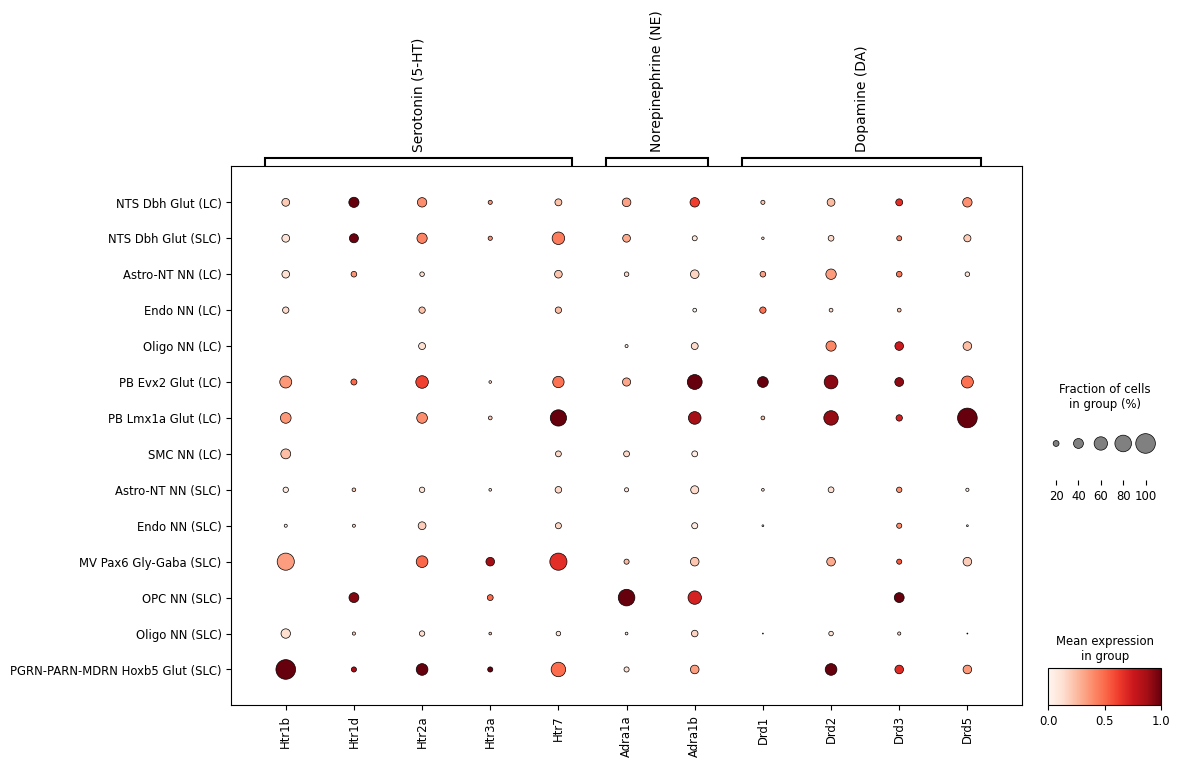

Saved: dotplot_LC_core_MERFISH.png


In [10]:
# Build AnnData for core LC+SLC
# Use subclass_short with structure annotation
core_meta['label'] = core_meta['subclass_short'] + ' (' + core_meta['structure'] + ')'

# Filter to groups with >= 5 cells (LC is small)
label_counts = core_meta.groupby('label', observed=True).size()
valid_labels = label_counts[label_counts >= 5].index.tolist()
mask_valid = core_meta['label'].isin(valid_labels)

adata_core = anndata.AnnData(
    X=core_expr.loc[mask_valid].values,
    obs=core_meta.loc[mask_valid, ['label', 'subclass_short', 'structure']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)

# Sort: Dbh+ first, then by structure, then alphabetically
def label_sort_key(label):
    is_dbh = 1 if 'Dbh' not in label else 0
    is_lc = 0 if '(LC)' in label else 1
    return (is_dbh, is_lc, label)

sorted_labels = sorted(valid_labels, key=label_sort_key)
adata_core.obs['label'] = pd.Categorical(
    adata_core.obs['label'], categories=sorted_labels, ordered=True
)

receptor_groups = {
    'Serotonin (5-HT)': [g for g in serotonin_receptors if g in receptor_genes],
    'Norepinephrine (NE)': [g for g in norepinephrine_receptors if g in receptor_genes],
    'Dopamine (DA)': [g for g in dopamine_receptors if g in receptor_genes],
}

n_labels = len(sorted_labels)
print(f'Groups with >= 5 cells: {n_labels}')
for lbl in sorted_labels:
    print(f'  {lbl}: {label_counts[lbl]} cells')

dp = sc.pl.dotplot(
    adata_core,
    var_names=receptor_groups,
    groupby='label',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(4, n_labels * 0.5)),
    show=False,
    return_fig=True
)
dp.style(dot_edge_color='black', dot_edge_lw=0.5)
dp.savefig('dotplot_LC_core_MERFISH.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: dotplot_LC_core_MERFISH.png')

## 6. Dot Plot: Neuronal Subclasses Across Peri-LC Structures

Compare receptor expression across the broader peri-LC pontine region,
focusing on neuronal cell types with sufficient cells.

Neuronal subclasses with >= 20 cells: 49
  NTS Dbh Glut: 215 cells (Nora)
  MB-MY Tph2 Glut-Sero: 80 cells (Sero)
  B-PB Nr4a2 Glut: 81 cells (Glut)
  CB Granule Glut: 137 cells (Glut)
  CU-ECU-SPVI Foxb1 Glut: 31 cells (Glut)
  CUN-PPN Evx2 Meis2 Glut: 213 cells (Chol)
  DCO UBC Glut: 28 cells (Glut)
  LDT-PCG Vsx2 Lhx4 Glut: 284 cells (Glut)
  MEV Ppp1r1c Glut: 48 cells (Glut)
  NLL-SOC Spp1 Glut: 25 cells (Glut)
  PB Evx2 Glut: 1,640 cells (Glut)
  PB Lmx1a Glut: 1,190 cells (Glut)
  PB Pax5 Glut: 260 cells (Glut)
  PB-NTS Phox2b Ebf3 Lmx1b Glut: 296 cells (Glut)
  PB-PSV Phox2b Glut: 32 cells (Glut)
  PB-SUT Tlx3 Lhx2 Glut: 78 cells (Glut)
  PCG-PRNr Vsx2 Nkx6-1 Glut: 109 cells (Glut)
  PG-TRN-LRN Fat2 Glut: 64 cells (Glut)
  PGRN-PARN-MDRN Hoxb5 Glut: 232 cells (Glut)
  PRNc-NI-SG-RPO Vsx2 Nr4a2 Glut: 26 cells (Glut)
  PRP-NI-PRNc-GRN Otp Glut: 86 cells (Glut)
  PSV Lmx1a Trpv6 Glut: 25 cells (Glut)
  PSV Pvalb Lhx2 Glut: 131 cells (Glut)
  CS-PRNr-DR En1 Sox2 Gaba: 50 cells (GABA

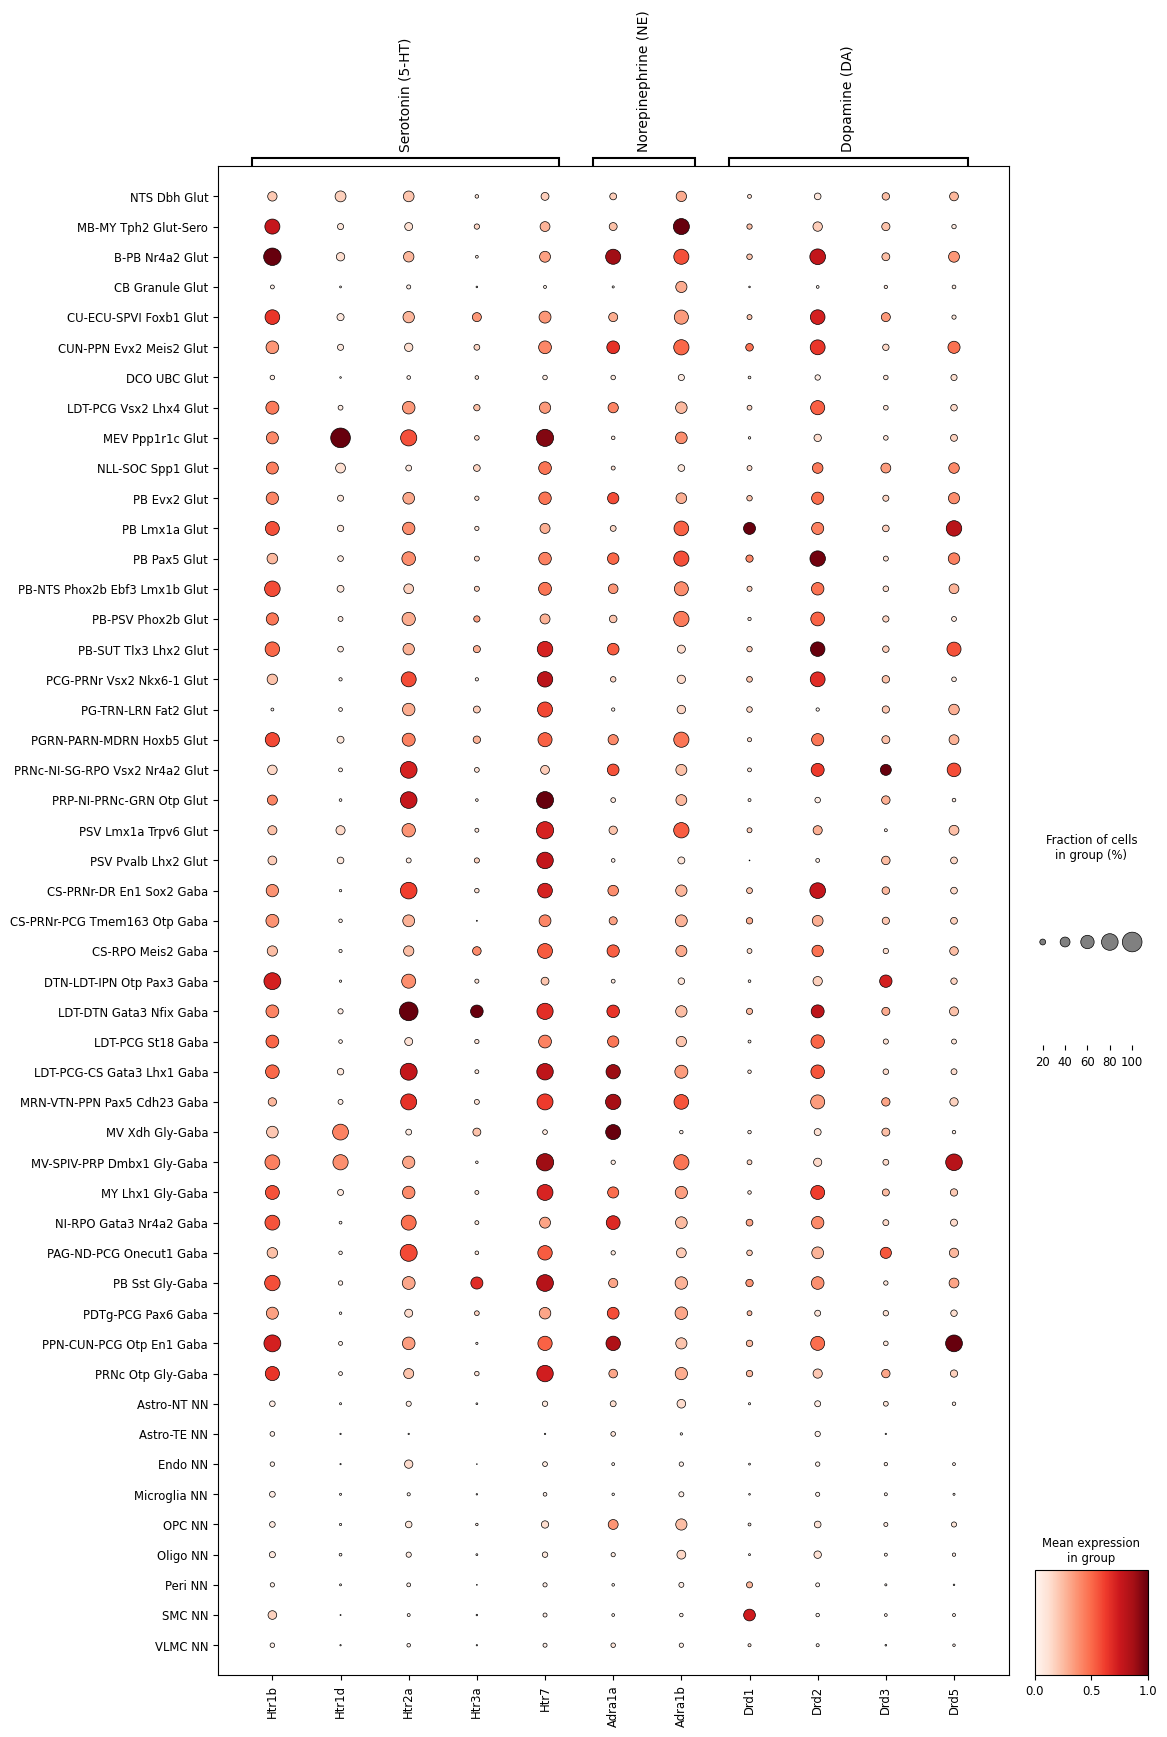

Saved: dotplot_LC_periLC_neuronal_MERFISH.png


In [11]:
# All neuronal cells across peri-LC
neuron_mask = ~meta['class'].str.contains('NN', na=False)
neuron_meta = meta[neuron_mask].copy()
neuron_expr = expression_data.loc[neuron_mask]

# Filter to subclasses with >= 20 cells
sc_counts = neuron_meta.groupby('subclass_short', observed=True).size()
valid_sc = sc_counts[sc_counts >= 20].index.tolist()
sc_mask = neuron_meta['subclass_short'].isin(valid_sc)

adata_neurons = anndata.AnnData(
    X=neuron_expr.loc[sc_mask].values,
    obs=neuron_meta.loc[sc_mask, ['subclass_short', 'structure', 'neurotransmitter']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)

# Sort: Dbh first, then by neurotransmitter (Glut, Gaba, Sero, etc.), then alpha
def sc_sort_key(name):
    if 'Dbh' in name:
        return (0, name)
    elif 'Tph2' in name or 'Sero' in name:
        return (1, name)
    elif 'Glut' in name:
        return (2, name)
    elif 'Gaba' in name or 'Gly' in name:
        return (3, name)
    else:
        return (4, name)

sorted_sc = sorted(valid_sc, key=sc_sort_key)
adata_neurons.obs['subclass_short'] = pd.Categorical(
    adata_neurons.obs['subclass_short'], categories=sorted_sc, ordered=True
)

n_sc = len(sorted_sc)
print(f'Neuronal subclasses with >= 20 cells: {n_sc}')
for sc_name in sorted_sc:
    cnt = sc_counts[sc_name]
    nt_mode = neuron_meta[neuron_meta['subclass_short'] == sc_name]['neurotransmitter'].mode()
    nt = nt_mode.iloc[0] if len(nt_mode) > 0 else 'unknown'
    print(f'  {sc_name}: {cnt:,} cells ({nt})')

dp2 = sc.pl.dotplot(
    adata_neurons,
    var_names=receptor_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(6, n_sc * 0.4)),
    show=False,
    return_fig=True
)
dp2.style(dot_edge_color='black', dot_edge_lw=0.5)
dp2.savefig('dotplot_LC_periLC_neuronal_MERFISH.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: dotplot_LC_periLC_neuronal_MERFISH.png')

## 7. Dot Plot: Noradrenergic (Dbh+) Neurons by Structure

Where do LC noradrenergic neurons reside, and do their receptor profiles
differ by location?

In [12]:
# Dbh+ neurons by structure
dbh_meta = meta[meta['subclass'].str.contains('Dbh', na=False)].copy()
dbh_expr = expression_data.loc[dbh_meta.index]

print(f'Dbh+ (noradrenergic) neurons in peri-LC: {len(dbh_meta):,}')

# By supertype and structure
dbh_meta['st_struct'] = dbh_meta['supertype_short'] + ' (' + dbh_meta['structure'] + ')'
combo_counts = dbh_meta.groupby('st_struct', observed=True).size().sort_values(ascending=False)
print(f'\nDbh+ supertype x structure (>= 3 cells):')
for combo, cnt in combo_counts.items():
    if cnt >= 3:
        print(f'  {combo}: {cnt} cells')

# Show by structure only (for dot plot, since cell counts are small)
struct_counts = dbh_meta.groupby('structure', observed=True).size().sort_values(ascending=False)
valid_structs_dbh = struct_counts[struct_counts >= 5].index.tolist()
print(f'\nStructures with >= 5 Dbh+ cells: {valid_structs_dbh}')

Dbh+ (noradrenergic) neurons in peri-LC: 215

Dbh+ supertype x structure (>= 3 cells):
  NTS Dbh Glut_4 (PB): 123 cells
  NTS Dbh Glut_4 (SLC): 31 cells
  NTS Dbh Glut_4 (LDT): 24 cells
  NTS Dbh Glut_4 (LC): 23 cells
  NTS Dbh Glut_4 (SLD): 12 cells

Structures with >= 5 Dbh+ cells: ['PB', 'SLC', 'LC', 'LDT', 'SLD']


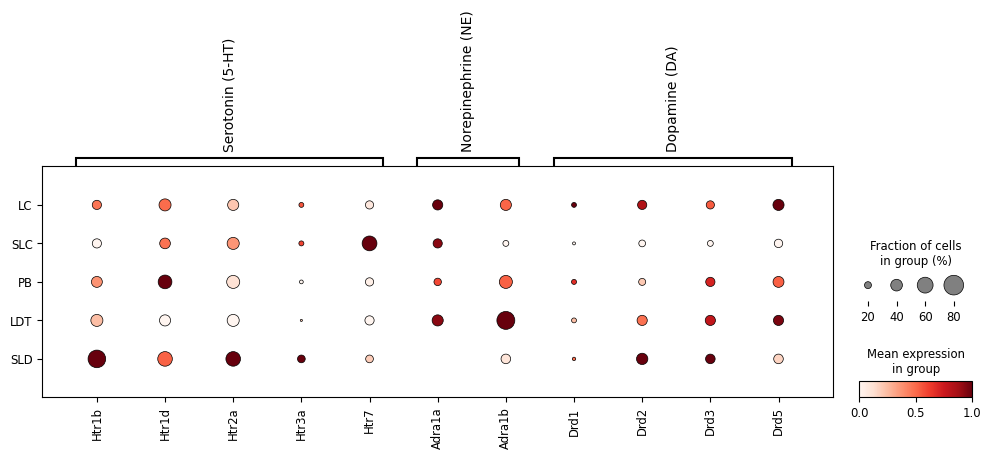

Saved: dotplot_LC_Dbh_by_structure_MERFISH.png


In [13]:
if len(valid_structs_dbh) >= 2:
    dbh_valid = dbh_meta[dbh_meta['structure'].isin(valid_structs_dbh)]
    dbh_expr_valid = dbh_expr.loc[dbh_valid.index]
    
    adata_dbh = anndata.AnnData(
        X=dbh_expr_valid.values,
        obs=dbh_valid[['structure', 'supertype_short']].copy(),
        var=pd.DataFrame(index=receptor_genes)
    )
    
    # Order structures: LC first, then by proximity
    struct_order = [s for s in ['LC', 'SLC', 'B', 'PB', 'LDT', 'SLD'] if s in valid_structs_dbh]
    adata_dbh.obs['structure'] = pd.Categorical(
        adata_dbh.obs['structure'], categories=struct_order, ordered=True
    )
    
    dp3 = sc.pl.dotplot(
        adata_dbh,
        var_names=receptor_groups,
        groupby='structure',
        standard_scale='var',
        cmap='Reds',
        figsize=(12, max(3, len(struct_order) * 0.6)),
        show=False,
        return_fig=True
    )
    dp3.style(dot_edge_color='black', dot_edge_lw=0.5)
    dp3.savefig('dotplot_LC_Dbh_by_structure_MERFISH.png', dpi=150, bbox_inches='tight')
    plt.show()
    print('Saved: dotplot_LC_Dbh_by_structure_MERFISH.png')
else:
    # If few structures, just show all Dbh by supertype
    adata_dbh = anndata.AnnData(
        X=dbh_expr.values,
        obs=dbh_meta[['structure', 'supertype_short']].copy(),
        var=pd.DataFrame(index=receptor_genes)
    )
    adata_dbh.obs['label'] = 'NE neuron (' + adata_dbh.obs['structure'] + ')'
    print(f'Only {len(valid_structs_dbh)} structures with >= 5 Dbh+ cells.')
    print('Showing as single group.')

## 8. Heatmap: Receptor Expression by Structure

Compare mean expression and fraction expressing across all peri-LC
structures for neuronal cells.

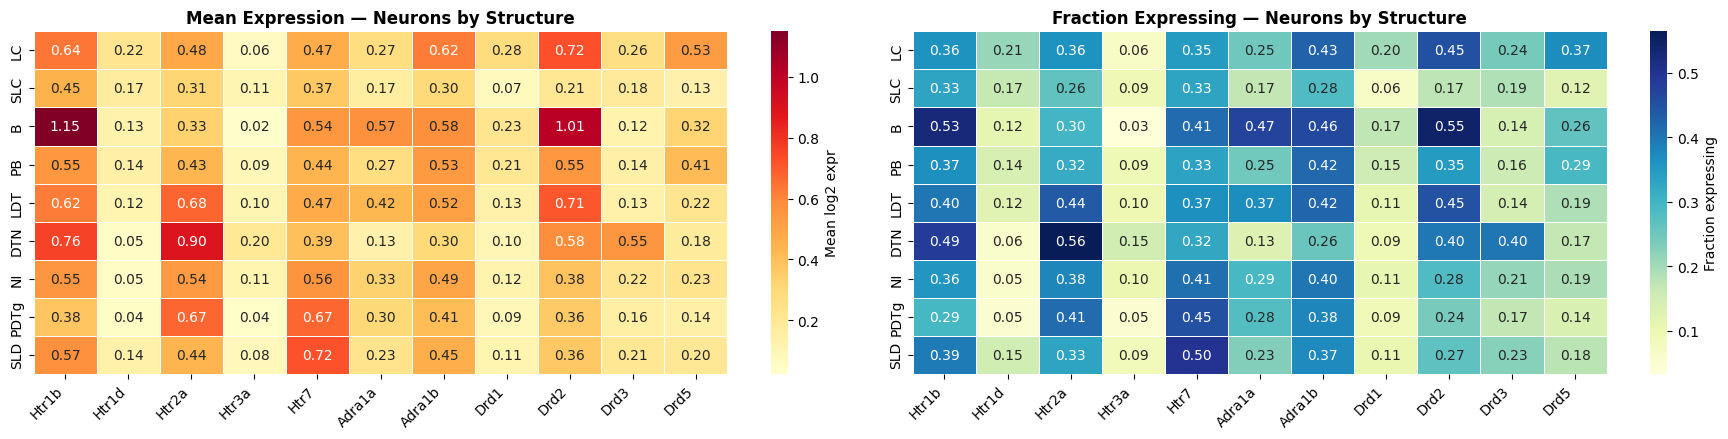

Saved: heatmap_LC_periLC_by_structure_MERFISH.png


In [14]:
# Mean expression and fraction by structure (neurons only)
neuron_df = pd.DataFrame(
    expression_data.loc[neuron_mask].values,
    index=neuron_meta.index,
    columns=receptor_genes
)
neuron_df['structure'] = neuron_meta['structure'].values

# Only structures with >= 20 neurons
struct_neuron_counts = neuron_meta.groupby('structure', observed=True).size()
valid_structs = struct_neuron_counts[struct_neuron_counts >= 20].index.tolist()

# Order: core first, then peri by cell count
struct_order_all = ['LC', 'SLC', 'B'] + [
    s for s in struct_neuron_counts.sort_values(ascending=False).index
    if s in valid_structs and s not in ['LC', 'SLC', 'B']
]
struct_order_all = [s for s in struct_order_all if s in valid_structs]

struct_mean = neuron_df[neuron_df['structure'].isin(valid_structs)].groupby(
    'structure', observed=True
)[receptor_genes].mean().loc[struct_order_all]

struct_frac = neuron_df[neuron_df['structure'].isin(valid_structs)].groupby(
    'structure', observed=True
)[receptor_genes].apply(lambda x: (x > 0).mean()).loc[struct_order_all]

n_structs = len(struct_order_all)

fig, axes = plt.subplots(1, 2, figsize=(18, max(4, n_structs * 0.5)))

sns.heatmap(struct_mean, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[0],
            linewidths=0.5, cbar_kws={'label': 'Mean log2 expr'})
axes[0].set_title('Mean Expression — Neurons by Structure', fontweight='bold')
axes[0].set_ylabel('')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

sns.heatmap(struct_frac, annot=True, fmt='.2f', cmap='YlGnBu', ax=axes[1],
            linewidths=0.5, cbar_kws={'label': 'Fraction expressing'})
axes[1].set_title('Fraction Expressing — Neurons by Structure', fontweight='bold')
axes[1].set_ylabel('')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('heatmap_LC_periLC_by_structure_MERFISH.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: heatmap_LC_periLC_by_structure_MERFISH.png')

## 9. Enrichment: LC vs Peri-LC Structures

Log2 fold-change of each structure relative to the overall peri-LC neuronal mean.

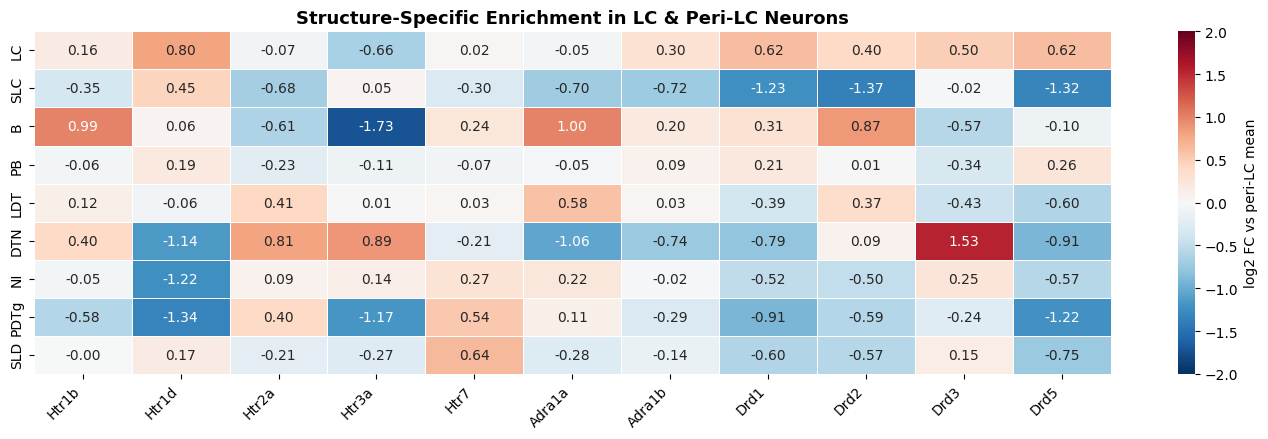

Saved: heatmap_LC_periLC_enrichment_MERFISH.png

Key enrichments (|log2FC| > 0.5):
  LC    : Htr1d(+0.8), Htr3a(-0.7), Drd1(+0.6), Drd5(+0.6)
  SLC   : Htr2a(-0.7), Adra1a(-0.7), Adra1b(-0.7), Drd1(-1.2), Drd2(-1.4), Drd5(-1.3)
  B     : Htr1b(+1.0), Htr2a(-0.6), Htr3a(-1.7), Adra1a(+1.0), Drd2(+0.9), Drd3(-0.6)
  LDT   : Adra1a(+0.6), Drd5(-0.6)
  DTN   : Htr1d(-1.1), Htr2a(+0.8), Htr3a(+0.9), Adra1a(-1.1), Adra1b(-0.7), Drd1(-0.8), Drd3(+1.5), Drd5(-0.9)
  NI    : Htr1d(-1.2), Drd1(-0.5), Drd5(-0.6)
  PDTg  : Htr1b(-0.6), Htr1d(-1.3), Htr3a(-1.2), Htr7(+0.5), Drd1(-0.9), Drd2(-0.6), Drd5(-1.2)
  SLD   : Htr7(+0.6), Drd1(-0.6), Drd2(-0.6), Drd5(-0.7)


In [15]:
# Enrichment relative to overall peri-LC neuronal mean
overall_neuron_mean = neuron_df[receptor_genes].mean()
pseudocount = 0.01
log2fc = np.log2((struct_mean + pseudocount) / (overall_neuron_mean + pseudocount))

fig, ax = plt.subplots(figsize=(14, max(4, n_structs * 0.5)))
sns.heatmap(log2fc, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            ax=ax, linewidths=0.5, vmin=-2, vmax=2,
            cbar_kws={'label': 'log2 FC vs peri-LC mean'})
ax.set_title('Structure-Specific Enrichment in LC & Peri-LC Neurons',
             fontweight='bold', fontsize=13)
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('heatmap_LC_periLC_enrichment_MERFISH.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: heatmap_LC_periLC_enrichment_MERFISH.png')

print('\nKey enrichments (|log2FC| > 0.5):')
for struct in struct_order_all:
    hits = []
    for g in receptor_genes:
        fc = log2fc.loc[struct, g]
        if abs(fc) > 0.5:
            direction = '+' if fc > 0 else '-'
            hits.append(f'{g}({direction}{abs(fc):.1f})')
    if hits:
        print(f'  {struct:6s}: {", ".join(hits)}')

## 10. Focus: Noradrenergic LC Neurons — Receptor Profile

Detailed look at the receptor expression profile of LC Dbh+ noradrenergic
neurons, the primary output cells of the locus coeruleus.

Dbh+ neurons (all peri-LC): 215 cells
Dbh+ neurons (LC only): 24 cells


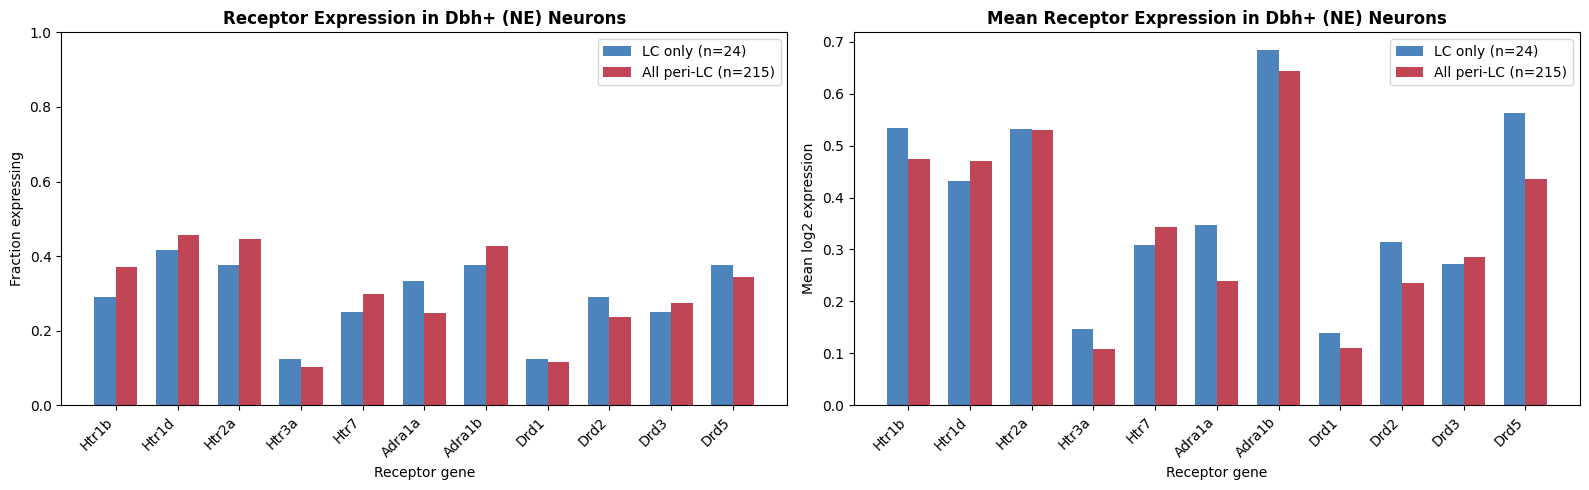

Saved: barplot_LC_Dbh_receptor_profile_MERFISH.png


In [16]:
# Focus on Dbh+ neurons (all structures combined, since LC alone has only ~24)
dbh_all_expr = expression_data.loc[dbh_meta.index]
dbh_frac = (dbh_all_expr > 0).mean()
dbh_mean = dbh_all_expr.mean()

# Also compute for LC-only Dbh+ neurons
dbh_lc = dbh_meta[dbh_meta['structure'] == 'LC']
if len(dbh_lc) > 0:
    dbh_lc_expr = expression_data.loc[dbh_lc.index]
    dbh_lc_frac = (dbh_lc_expr > 0).mean()
    dbh_lc_mean = dbh_lc_expr.mean()

print(f'Dbh+ neurons (all peri-LC): {len(dbh_meta)} cells')
print(f'Dbh+ neurons (LC only): {len(dbh_lc)} cells')

# Bar chart of fraction expressing for LC Dbh+ neurons
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Fraction expressing
x = np.arange(len(receptor_genes))
width = 0.35

ax = axes[0]
if len(dbh_lc) > 0:
    bars1 = ax.bar(x - width/2, dbh_lc_frac[receptor_genes], width, label=f'LC only (n={len(dbh_lc)})',
                   color='#2166ac', alpha=0.8)
    bars2 = ax.bar(x + width/2, dbh_frac[receptor_genes], width, label=f'All peri-LC (n={len(dbh_meta)})',
                   color='#b2182b', alpha=0.8)
else:
    bars2 = ax.bar(x, dbh_frac[receptor_genes], width, label=f'All peri-LC (n={len(dbh_meta)})',
                   color='#b2182b', alpha=0.8)
ax.set_xlabel('Receptor gene')
ax.set_ylabel('Fraction expressing')
ax.set_title('Receptor Expression in Dbh+ (NE) Neurons', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(receptor_genes, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)

# Mean expression
ax = axes[1]
if len(dbh_lc) > 0:
    ax.bar(x - width/2, dbh_lc_mean[receptor_genes], width, label=f'LC only (n={len(dbh_lc)})',
           color='#2166ac', alpha=0.8)
    ax.bar(x + width/2, dbh_mean[receptor_genes], width, label=f'All peri-LC (n={len(dbh_meta)})',
           color='#b2182b', alpha=0.8)
else:
    ax.bar(x, dbh_mean[receptor_genes], width, label=f'All peri-LC (n={len(dbh_meta)})',
           color='#b2182b', alpha=0.8)
ax.set_xlabel('Receptor gene')
ax.set_ylabel('Mean log2 expression')
ax.set_title('Mean Receptor Expression in Dbh+ (NE) Neurons', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(receptor_genes, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig('barplot_LC_Dbh_receptor_profile_MERFISH.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved: barplot_LC_Dbh_receptor_profile_MERFISH.png')

In [17]:
# Summary table for LC Dbh+ neurons
print('=' * 70)
print('Receptor Profile of Dbh+ (Noradrenergic) Neurons')
print('=' * 70)
print(f'\n{"Gene":>10s}  {"Frac(LC)":>10s}  {"Mean(LC)":>10s}  {"Frac(all)":>10s}  {"Mean(all)":>10s}')
print('-' * 55)
for g in receptor_genes:
    if len(dbh_lc) > 0:
        print(f'{g:>10s}  {dbh_lc_frac[g]:>10.3f}  {dbh_lc_mean[g]:>10.3f}  '
              f'{dbh_frac[g]:>10.3f}  {dbh_mean[g]:>10.3f}')
    else:
        print(f'{g:>10s}  {"n/a":>10s}  {"n/a":>10s}  '
              f'{dbh_frac[g]:>10.3f}  {dbh_mean[g]:>10.3f}')

Receptor Profile of Dbh+ (Noradrenergic) Neurons

      Gene    Frac(LC)    Mean(LC)   Frac(all)   Mean(all)
-------------------------------------------------------
     Htr1b       0.292       0.533       0.372       0.474
     Htr1d       0.417       0.432       0.456       0.470
     Htr2a       0.375       0.532       0.447       0.530
     Htr3a       0.125       0.147       0.102       0.108
      Htr7       0.250       0.309       0.298       0.343
    Adra1a       0.333       0.347       0.247       0.238
    Adra1b       0.375       0.684       0.428       0.644
      Drd1       0.125       0.140       0.116       0.110
      Drd2       0.292       0.315       0.237       0.236
      Drd3       0.250       0.272       0.274       0.286
      Drd5       0.375       0.563       0.344       0.435


## 11. Summary Statistics

In [18]:
print('=' * 70)
print('Mean Expression (log2) — Neurons by Structure (peri-LC)')
print('=' * 70)
display(struct_mean.round(3))

print('\n' + '=' * 70)
print('Fraction Expressing — Neurons by Structure (peri-LC)')
print('=' * 70)
display(struct_frac.round(3))

# Save summary CSVs
struct_mean.to_csv('lc_periLC_structure_mean_expression.csv')
struct_frac.to_csv('lc_periLC_structure_frac_expressing.csv')
log2fc.to_csv('lc_periLC_structure_enrichment.csv')
print('\nSaved summary CSVs.')

print(f'\n{"=" * 70}')
print('Summary')
print(f'{"=" * 70}')
print(f'Total cells: {len(expression_data):,} ({len(lc_region[lc_region["is_neuronal"]]):,} neurons)')
print(f'Core LC cells: {core_mask.sum():,} (LC: {(meta["structure"]=="LC").sum()}, SLC: {(meta["structure"]=="SLC").sum()})')
print(f'Dbh+ (NE) neurons: {len(dbh_meta):,} ({len(dbh_lc)} in LC proper)')
print(f'Structures: {n_structs} with >= 20 neurons')
print(f'Receptor genes: {len(receptor_genes)}')

Mean Expression (log2) — Neurons by Structure (peri-LC)


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
structure,,,,,,,,,,,
LC,0.639,0.219,0.483,0.061,0.465,0.271,0.622,0.280,0.725,0.265,0.534
SLC,0.448,0.169,0.311,0.106,0.370,0.169,0.300,0.071,0.205,0.183,0.133
B,1.150,0.127,0.328,0.024,0.543,0.570,0.578,0.225,1.009,0.122,0.321
PB,0.549,0.140,0.429,0.094,0.436,0.272,0.535,0.209,0.549,0.144,0.414
LDT,0.622,0.116,0.676,0.103,0.470,0.425,0.515,0.135,0.709,0.134,0.225
DTN,0.759,0.050,0.896,0.198,0.395,0.130,0.297,0.100,0.583,0.553,0.179
NI,0.552,0.046,0.538,0.114,0.557,0.330,0.494,0.122,0.385,0.222,0.229
PDTg,0.379,0.042,0.672,0.040,0.674,0.304,0.410,0.091,0.359,0.155,0.143
SLD,0.571,0.138,0.437,0.083,0.723,0.230,0.455,0.115,0.364,0.206,0.202



Fraction Expressing — Neurons by Structure (peri-LC)


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
structure,,,,,,,,,,,
LC,0.363,0.210,0.363,0.065,0.347,0.250,0.427,0.202,0.452,0.242,0.371
SLC,0.332,0.166,0.265,0.094,0.332,0.170,0.283,0.063,0.175,0.188,0.121
B,0.529,0.116,0.298,0.033,0.413,0.471,0.463,0.174,0.545,0.140,0.264
PB,0.366,0.137,0.319,0.093,0.334,0.247,0.419,0.154,0.347,0.156,0.291
LDT,0.400,0.123,0.437,0.096,0.367,0.370,0.421,0.111,0.450,0.143,0.191
DTN,0.485,0.057,0.564,0.148,0.324,0.128,0.255,0.093,0.397,0.401,0.170
NI,0.356,0.054,0.379,0.103,0.408,0.292,0.402,0.112,0.284,0.213,0.191
PDTg,0.293,0.048,0.413,0.048,0.454,0.280,0.378,0.091,0.239,0.172,0.135
SLD,0.392,0.151,0.333,0.086,0.500,0.228,0.374,0.108,0.266,0.226,0.177



Saved summary CSVs.

Summary
Total cells: 15,841 (15,841 neurons)
Core LC cells: 347 (LC: 124, SLC: 223)
Dbh+ (NE) neurons: 215 (24 in LC proper)
Structures: 9 with >= 20 neurons
Receptor genes: 11
